In [1]:
"""
Created on Thu Sep  2 15:57:15 2021

@author: paula

El propósito de este script es agarrar los datos de todos los sujetos,
pasarlos por distintos criterios de outliers (1 de trials y 2 de sujeto) y
quedarse solo con la información que va a servir después para el análisis.
El primer criterio por el que pasan los datos es para encontrar trials
outliers. Si algún valor de asincronía del trial está por fuera del intervalo
(promedio del trial-umbral, promedio del trial + umbral), entonces el trial es
outlier.
Con los trials que sobrevivieron a ese primer criterio, se calcula el promedio
across trials para cada condición para cada sujeto y se estudian dos criterios
para determinar si un sujeto es outlier.
1. Si el promedio de sus trials para una condición está fuera de la campana
principal de distribución de promedios, entonces el sujeto es outlier.
2. Si el promedio de sus trials tiene un drift en una cierta condición,
entonces el sujeto es outlier.

Finalmente, con los sujetos y trials que hayan sobrevivido a estos criterios
armo una nueva matriz que tiene los datos totales de cada sujeto en cada
condición, una matriz con los datos ya promediados across trials y otra con
los datos ya promediados along trials. Además, guardo en un vector los números
identificatorios de cada sujeto para poder rastrearlo en los datos "totales"
si es necesario.

IMPORTANTE:
Para que el código funcione correctamente, los archivos .dat y .npz de los
trials tienen que estar dentro de una carpeta llamada Data en el directorio
donde se está trabajando.
"""

import numpy as np
import matplotlib.pyplot as plt
import glob
import pandas as pd

In [2]:
# %% DEFINO FUNCIONES


def Loading_data(subject_number, block, trial, *asked_data):
    '''
    Carga la información del sujeto y el bloque especificados.

    Hay que darle si o si numero de sujeto y bloque, mientras que el trial
    puede estar especificado con el número o ser None. Recordar que los
    archivos que no tienen identificado el trial tienen guardada la informacion
    de todo el bloque: condicion usada, errores, percepcion del sujeto y si el
    trial fue valido o invalido. En cambio, al especificar el trial se tiene la
    informacion de cada trial particular, es decir, asincronias, datos crudos,
    respuestas y estimulos.

    Disclaimer: el archivo sólo carga la información, no la procesa de ninguna
    forma. En muchos casos la información se carga como bytes, entonces es
    necesario ser cuidadoso con cómo se maneja cada cosa cargada.
    '''

    subject_number_format = '{0:0>3}'.format(subject_number)

    # Depending on getting "None" or a number for input trial, defines a
    # different filename to load.
    if trial is None:
        file_to_load = glob.glob('Data/S'
                                 + subject_number_format
                                 + "*-block"
                                 + str(block)
                                 + "-trials.npz")
    else:
        file_to_load = glob.glob('Data/S'
                                 + subject_number_format
                                 + "*-block"
                                 + str(block)
                                 + "-trial"
                                 + str(trial)
                                 + ".npz")

    # Loads the file
    npz = np.load(file_to_load[0])
    # If the wanted data is not specified, the function prints all the data
    # you can ask for in that file chosen. Else, returns the wanted data.
    if len(asked_data) == 0:
        print("The file contains:")
        return sorted(npz)
    else:
        data_to_return = []
        for a in asked_data:
            data_to_return.append(npz[a])
        return data_to_return[:]


def Stim_Fdbk_conditions(subject_number):
    '''
    Devuelve un vector con las condiciones de estímulo y feedback
    (en ese orden) realizadas por el sujeto en el orden que las realizó
    (cada condición quedará asociada a un índice que llamamos número de bloque)

    Parameters
    ----------
    subject_number : TYPE int
        DESCRIPTION. Número asociado al sujeto

    Returns
    -------
    Vector con condiciones de estímulo y feedback en el orden realizado

    '''

    condit_subj = []
    # Voy mirando cada bloque y guardando la información en los vectores que
    # acabo de crear. Acá el rango es 5 porque sólo hay 5 condiciones
    for i in range(5):
        # Cargo las condiciones en que se realizaron los trials en el bloque i
        conditions = Loading_data(subject_number, i, None, 'conditions')
        # Como por bloque mantenemos la condición, me da igual tomar
        # cualquier trial de ejemplo, así que agarro el primero.
        condit_block_decode = conditions[0][0].decode('utf-8')
        condit_stim_block = condit_block_decode[2]
        condit_fdbk_block = condit_block_decode[5]
        condit_subj.append(condit_stim_block + condit_fdbk_block)

    return condit_subj


def Find_block(subject_number, condition):
    '''
    Devuelve el número de bloque en el que un sujeto realizó el experimento en
    la condición especificada.

    Parameters
    ----------
    subject_number : TYPE int
        DESCRIPTION. Número asociado al sujeto
    condition : TYPE str
        DESCRIPTION. 'LL', 'RR', 'BB', 'RL' or 'LR'

    Returns
    -------
    int. Número de bloque en que el sujeto trabajó en cierta condición
    '''

    # Obtengo las condiciones de estímulo y feedback en las que trabajó el
    # sujeto en orden
    condit_subj = Stim_Fdbk_conditions(subject_number)
    # Search for the index of the specified condition in the inputs
    if condition in condit_subj:
        return condit_subj.index(condition)


def trial_outlier_respect2mean(subject_number, block, condition,
                               trial, asynch_vector):
    '''
    Checks if it's an outlier based on whether it has any asynchrony bigger
    than threshold_outliers from the mean of the trial.

    Parameters
    ----------
    subject_number : TYPE int
        DESCRIPTION. Número de sujeto
    block : TYPE int
        DESCRIPTION. Número de bloque
    condition : TYPE str
        DESCRIPTION. 'LL', 'RR', 'BB', 'RL' or 'LR'. Esta información solo es
        necesaria para realizar el gráfico en caso de que el trial sea outlier.
    trial : TYPE int
        DESCRIPTION. Número de trial. Esta información solo es necesaria para
        realizar el gráfico en caso de que el trial sea outlier.
    asynch_vector : TYPE vector
        DESCRIPTION. Es el trial en sí mismo. Un vector con los valores de
        asincronía. Esta función analiza trials individuales, por eso trabaja
        sobre un único trial.

    Returns
    -------
    True si el trial pasó el criterio de outlier, False si no.

    '''

    # Define a threshold to find new outliers
    threshold_outliers = 110

    trial_mean = np.mean(asynch_vector)
    dif_vector = [abs(trial_mean-asynch_vector[k])
                  for k in range(len(asynch_vector))]

    if max(dif_vector) > threshold_outliers:
        # UNCOMMENT THE FOLLOWING IF YOU WISH TO SEE WHICH TRIALS ARE OUTLIERS

        # print('El trial %i de la condicion %s(B%i) del sujeto S%s es outlier'
        #       % (trial, condition, block, subject_number))
        # plt.figure()
        # plt.figure(figsize=(10, 8))

        # plt.plot(asynch_vector, '.-', label='Trial %d' % trial)
        # plt.hlines(trial_mean, 0, 40, color='k', linestyle='solid',
        #            label='Asincronia promedio')
        # plt.hlines(trial_mean-threshold_outliers, 0, 40, color='gray',
        #            linestyle='dashed')
        # plt.hlines(trial_mean+threshold_outliers, 0, 40, color='gray',
        #            linestyle='dashed')
        # plt.xlabel('# bip', fontsize=18)
        # plt.ylabel('Asincronia[ms]', fontsize=18)
        # plt.xticks(fontsize=18)
        # plt.yticks(fontsize=18)
        # plt.grid(True)
        # plt.legend(fontsize=15)
        # plt.title('Trial Outlier - Sujeto %s, Condicion %s%s'
        #           % (subject_number,cond_pair[0],cond_pair[1]),fontsize=15)

        # plt.savefig('trials_outliers_S%s_%s%s_Trial%i.png'
        #             % (subject_number,cond_pair[0],cond_pair[1],trial))

        return False

    # If all asynchronies are whithin the mean+/-threshold, then trial is
    # not an outlier
    else:
        return True


def trials_matrix_fun(subject_number, block, condition, valid_index):
    '''
    Devuelve la matriz de trials válidos de un sujeto, ya recortados (sin la
    parte transitoria) y habiendo pasado por el criterio de outlier respecto
    al valor medio del trial (ver función trial_outlier_respect2mean).

    Parameters
    ----------
    subject_number : TYPE int
        DESCRIPTION. Número de sujeto
    block : TYPE int
        DESCRIPTION. Número de bloque
    condition : TYPE str
        DESCRIPTION. 'LL', 'RR', 'BB', 'RL' or 'LR'. Esta información solo es
        necesaria para realizar el gráfico en caso de que el trial sea outlier
        (ver función trial_outlier_respect2mean).
    valid_index : TYPE vector
        DESCRIPTION. Contiene 1's y 0's según si el trial fue válido o no

    Returns
    -------
    Una lista de listas: una lista que contiene los diferentes trials, que a
    su vez contienen los valores de asincronía.

    '''

    # Won't take all beeps in a trial: gets last N_transit beeps assuring it
    # has disregarded at least 5 at the beginning. That's why we need the
    # asynchronies' vector to have a minimum length
    N_transit = 40
    min_len_asynch_vector = N_transit + 5

    trials_matrix = []
    # Search for outliers
    for trial in valid_index:
        asynch = Loading_data(subject_number, block, trial, 'asynch')

        # Get rid of transitory stage
        if len(asynch[0]) > min_len_asynch_vector:
            asynch_notTrans = asynch[0][-N_transit:]

        else:
            print("Asynch vector from trial %i is not long enough" % trial)
            return

        if trial_outlier_respect2mean(subject_number, block, condition, trial,
                                      asynch_notTrans):
            trials_matrix.append(asynch_notTrans)

    return trials_matrix


In [5]:
# %%


'''
After running this block you'll have an alldata DataFrame which allows access
to trials explicitly calling on a condition (columns) and/or a subject (rows).
Trials are all valid trials already cleaned up from the transition part and
have gone through an outlier filter (studying if any asynchrony value crosses
a threshold with respect to the trial's mean value).
'''

condition_vector = ['LL', 'RR', 'BB', 'RL', 'LR']
total_number_subjects = 5

# Creo el DataFrame vacío (sé de antemano cantidad de condiciones y sujetos)
alldata = pd.DataFrame([],
                       columns=condition_vector,
                       index=['sujeto %i'
                              % i for i in range(1, total_number_subjects+1)])

for subject_number in range(1, total_number_subjects+1):
    for condition in condition_vector:
        # Find the block in which this subject worked in this condition
        block = Find_block(subject_number, condition)
        # Load the file that says which trials were valid
        trials = Loading_data(subject_number, block, None, 'trials')

        # Me quedo con trials válidos (guardo sus índices)
        valid_index = [indice for indice in range(len(trials[0]))
                       if trials[0][indice] == 1]

        # Build a matrix with all valid trials without transitory part
        trials_matrix = trials_matrix_fun(subject_number, block, condition,
                                          valid_index)
        # Make it into a DataFrame
        trialsdf = pd.DataFrame(trials_matrix,
                                columns=['beep%i'
                                         % i for i in range(40)],
                                index=['trial%i'
                                       % i for i in range(len(trials_matrix))])

        # Locate the new DataFrame in the main DF where it belongs
        alldata[condition]['sujeto %i' % subject_number] = trialsdf

El sujeto S003 tiene drift en la condicion BB


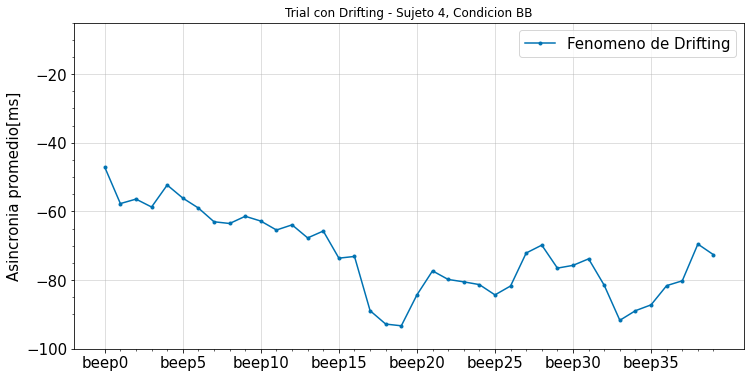

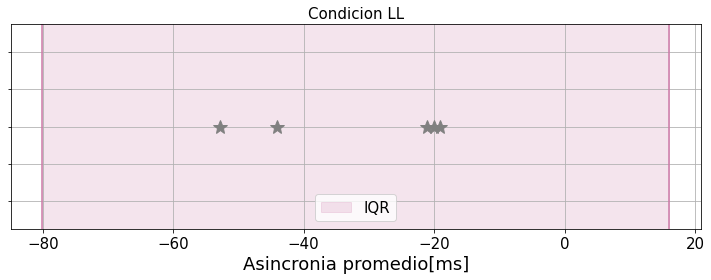

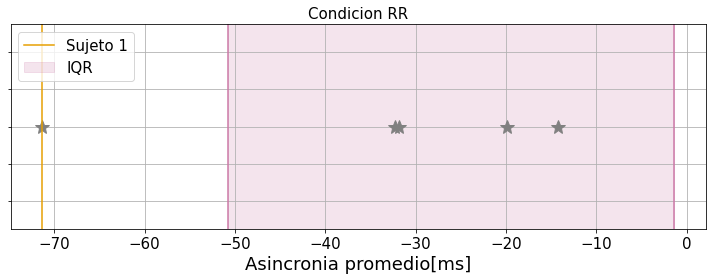

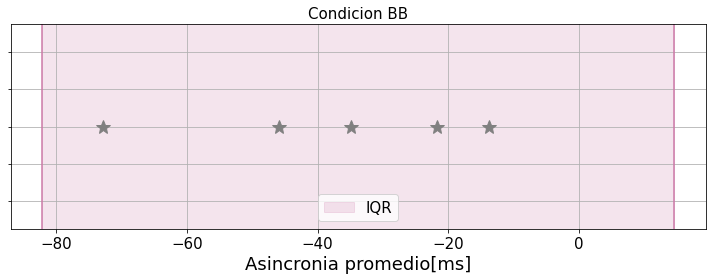

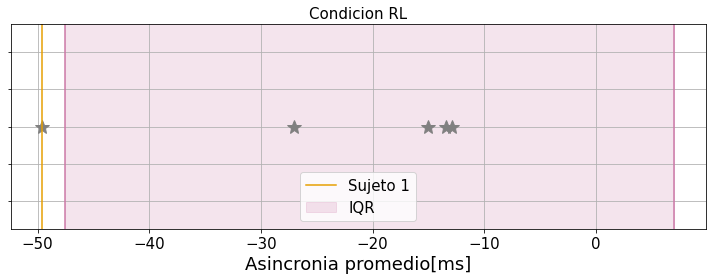

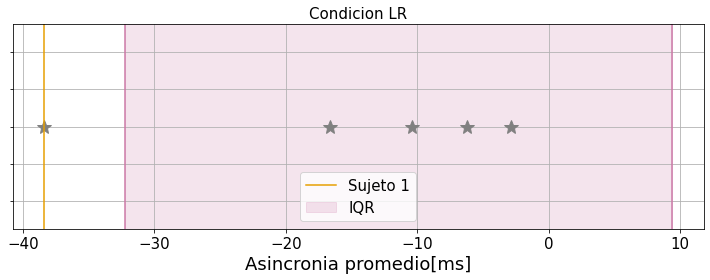

In [6]:
# %%


'''
Now we study if any of the subjects were outliers with two filters:
    1. Drifting
    2. Mean distribution
In both cases we'll be working with mean values of asynchrony. The mean value
is calculated across trials (same beep number) for an specific subject and
condition: alldata[condition][subj_number].mean()
This leaves us with a "mean trial" for each subject in each condition.
If any subject is an outlier, it's removed from the all_subjects vector.
'''

all_subjects = list(np.arange(1, total_number_subjects+1))

# Paleta Colorblind-friendly for plots
cbPaleta = ["#999999", "#E69F00", "#56B4E9", "#009E73", "#F0E442", "#0072B2",
            "#D55E00", "#CC79A7", "#999999", "#E69F00", "#56B4E9", "#009E73",
            "#F0E442", "#0072B2", "#D55E00", "#CC79A7"]


# DRIFTING
# Defino una diferencia máxima aceptable entre el valor promedio de asincronía
# de dos tramos del trial promedio. Si el sujeto supera esa diferencia en
# alguna de las condiciones, se considera sujeto outlier y se lo descarta.
max_dif_accept = 20

for condition in condition_vector:
    for subj_number in all_subjects:
        x_firsthalf = alldata[condition]['sujeto %i'
                                         % subj_number].mean()[0:15].mean()
        x_secondhalf = alldata[condition]['sujeto %i'
                                          % subj_number].mean()[15:40].mean()

        if abs(x_firsthalf-x_secondhalf) > max_dif_accept:
            print('El sujeto S00%i tiene drift en la condicion %s'
                  % (subj_number, condition))

            # Hago el plot del trial promedio que dio con drifting
            fig = plt.figure(figsize=(12, 6))
            ax = fig.add_subplot(1, 1, 1)
            plt.plot(alldata[condition]['sujeto %i' % subj_number].mean(),
                     '.-', color=cbPaleta[5], label='Fenomeno de Drifting')

            plt.ylabel('Asincronia promedio[ms]', fontsize=15)
            plt.xticks(fontsize=15)
            plt.yticks(fontsize=15)
            plt.grid(True)
            plt.legend(fontsize=15)

            # Embellecimiento de plot
            major_ticks = np.arange(-100, 0, 20)
            minor_ticks = np.arange(-90, 0, 5)
            major_ticks_y = np.arange(0, 40, 5)
            minor_ticks_y = np.arange(0, 40, 1)

            ax.set_xticks(major_ticks_y)
            ax.set_xticks(minor_ticks_y, minor=True)
            ax.set_yticks(major_ticks)
            ax.set_yticks(minor_ticks, minor=True)
            ax.grid(which='both')
            ax.grid(which='minor', alpha=0.2)
            ax.grid(which='major', alpha=0.5)

            plt.title('Trial con Drifting - Sujeto %i, Condicion %s'
                      % (subj_number+1, condition))
            # plt.savefig('Outlier_drifting.png')

            # Saco al sujeto de la lista de sujetos
            all_subjects.remove(subj_number)


# DISTRIBUCION DE PROMEDIOS
# Para aplicar este criterio voy a promediar sobre los trials promedio,
# obteniendo un único valor de asincronía promedio por sujeto por condición.
# Como luego voy a querer graficar dichos valores, me conviene guardarlos en
# un nuevo DataFrame.
meandata = pd.DataFrame([],
                        columns=condition_vector,
                        index=['sujeto %i'
                               % i for i in range(1, total_number_subjects+1)])

for condition in condition_vector:
    for subj_number in range(1, total_number_subjects+1):
        meandata[condition]['sujeto %i' % subj_number] = (
            alldata[condition]['sujeto %i' % subj_number].mean().mean())

# Ahora sí, grafico y testeo
for condition in condition_vector:

    x = meandata[condition]
    x_y = np.zeros(len(x))
    perc_25 = np.percentile(x, 25)
    perc_75 = np.percentile(x, 75)
    iqr = perc_75 - perc_25
    lim_sup = perc_75 + 1.5*iqr
    lim_inf = perc_25 - 1.5*iqr

    plt.figure(figsize=(10, 4))
    plt.plot(x, x_y, '*', color='gray', markersize=15)

    # Me fijo si algún sujeto escapa la distribución de promedios y lo señalo
    # en el plot y lo saco de la lista de sujetos
    for i in range(total_number_subjects):
        if x[i] > lim_sup:
            plt.axvline(x[i], color=cbPaleta[1], label='Sujeto %i' % (i+1))
            # Esto es necesario porque un mismo sujeto puede resultar outlier
            # con este criterio en diferentes condiciones, entonces cuando
            # intenta remover un sujeto que ya no está en el vector, da error.
            try:
                all_subjects.remove(i+1)
            except ValueError:
                pass
        elif x[i] < lim_inf:
            plt.axvline(x[i], color=cbPaleta[1], label='Sujeto %i' % (i+1))
            try:
                all_subjects.remove(i+1)
            except ValueError:
                pass

    plt.axvline(lim_inf, color=cbPaleta[7])
    plt.axvline(lim_sup, color=cbPaleta[7])
    plt.axvspan(lim_inf, lim_sup, alpha=0.2, color=cbPaleta[7], label='IQR')
    plt.xlabel('Asincronia promedio[ms]', fontsize=18)
    plt.xticks(fontsize=15)
    plt.yticks(visible=False)
    plt.grid()
    plt.legend(fontsize=15)
    plt.title('Condicion %s' % condition, fontsize=15)
    plt.tight_layout()
    # plt.savefig('DistribAsinc_Cond%s.png' % condition)

In [7]:
# %%


'''
Finalmente, se puede armar un DataFrame con la información solo de los sujetos
que no son outliers y guardarla en un archivo con el que se trabaja después.
Nota: en el archivo original acá se calculan los promedios across y along trial
(con sus respectivos errores) para ponerlos en el archivo. Trabajando con
DataFrames resultó más conveniente sólo guardar la información de los trials
enteros y calcular los promedios después.
También, en el archivo original usabamos .npz, con Python 3.7 y los DataFrames
resultó más conveniente guardarlo en un .pkl.
'''

validsubj = pd.DataFrame([], columns=condition_vector, index=['sujeto %i'
                         % i for i in range(1, len(all_subjects)+1)])

for condition in condition_vector:
    for i, suj in enumerate(all_subjects):
        validsubj[condition]['sujeto %i' % (i+1)] = (
            alldata[condition]['sujeto %i' % suj])

validsubj.to_pickle("valid_subjects_data_PICKL.pkl")
